In [1]:
import typhon_model
# from architecture_loader import ArchitectureLoader
import torch.nn as nn
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
# import random

In [2]:
# Use model of group AE10 (which passes the top k features plus the coordinates)
MODEL_PATH = './results_atari/20230121_topk10_k_2/models/train_model_p.pth' 

In [3]:
envs = ['DemonAttack-v5', 'FishingDerby-v5', 'Frostbite-v5', 'Kangaroo-v5', 'NameThisGame-v5', 'Phoenix-v5', 'Qbert-v5', 'Seaquest-v5', 'SpaceInvaders-v5', 'TimePilot-v5'],
# ENV_NAME = 'Seaquest-v5'

INPUT_FOLDER = f'/home/jonas/Desktop/SmallDataAtari/'

In [4]:
def load_npy(path):
    ary = np.load(path)
    # Move color channel in front
    ary = ary.transpose(2, 0, 1)
    # print(ary.shape)
    # Normalize
    ary = np.divide(ary, 255)
    ary.shape = (1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    return img

def plottable_image(tensor):
    # .npy where created with cv2, meaning it uses BGR. Plt plots using RGB. Exchange them
    #   using [...,::-1]
    return (tensor[0].cpu().detach().numpy().transpose(1, 2, 0) * 255)[...,::-1].astype('uint8')

In [5]:
def unflatten_coords(idx, shape):
    rest = shape
    coords = []
    divisor = 1
    while rest:
        *rest, curr = rest
        # if not rest: break
        coords.append(idx // divisor % curr) # or modify idx (idx // divisor) each loop
        divisor *= curr
    return coords

In [6]:
# Load model
model_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model = typhon_model.TyphonModel.from_state_dict(model_dict)

In [7]:
# list(model.modules())[0].fe

In [8]:
# dir(model)
# w = list(list(model.modules())[0].fe[0].parameters())[0][0][0]
# w > 1e-1

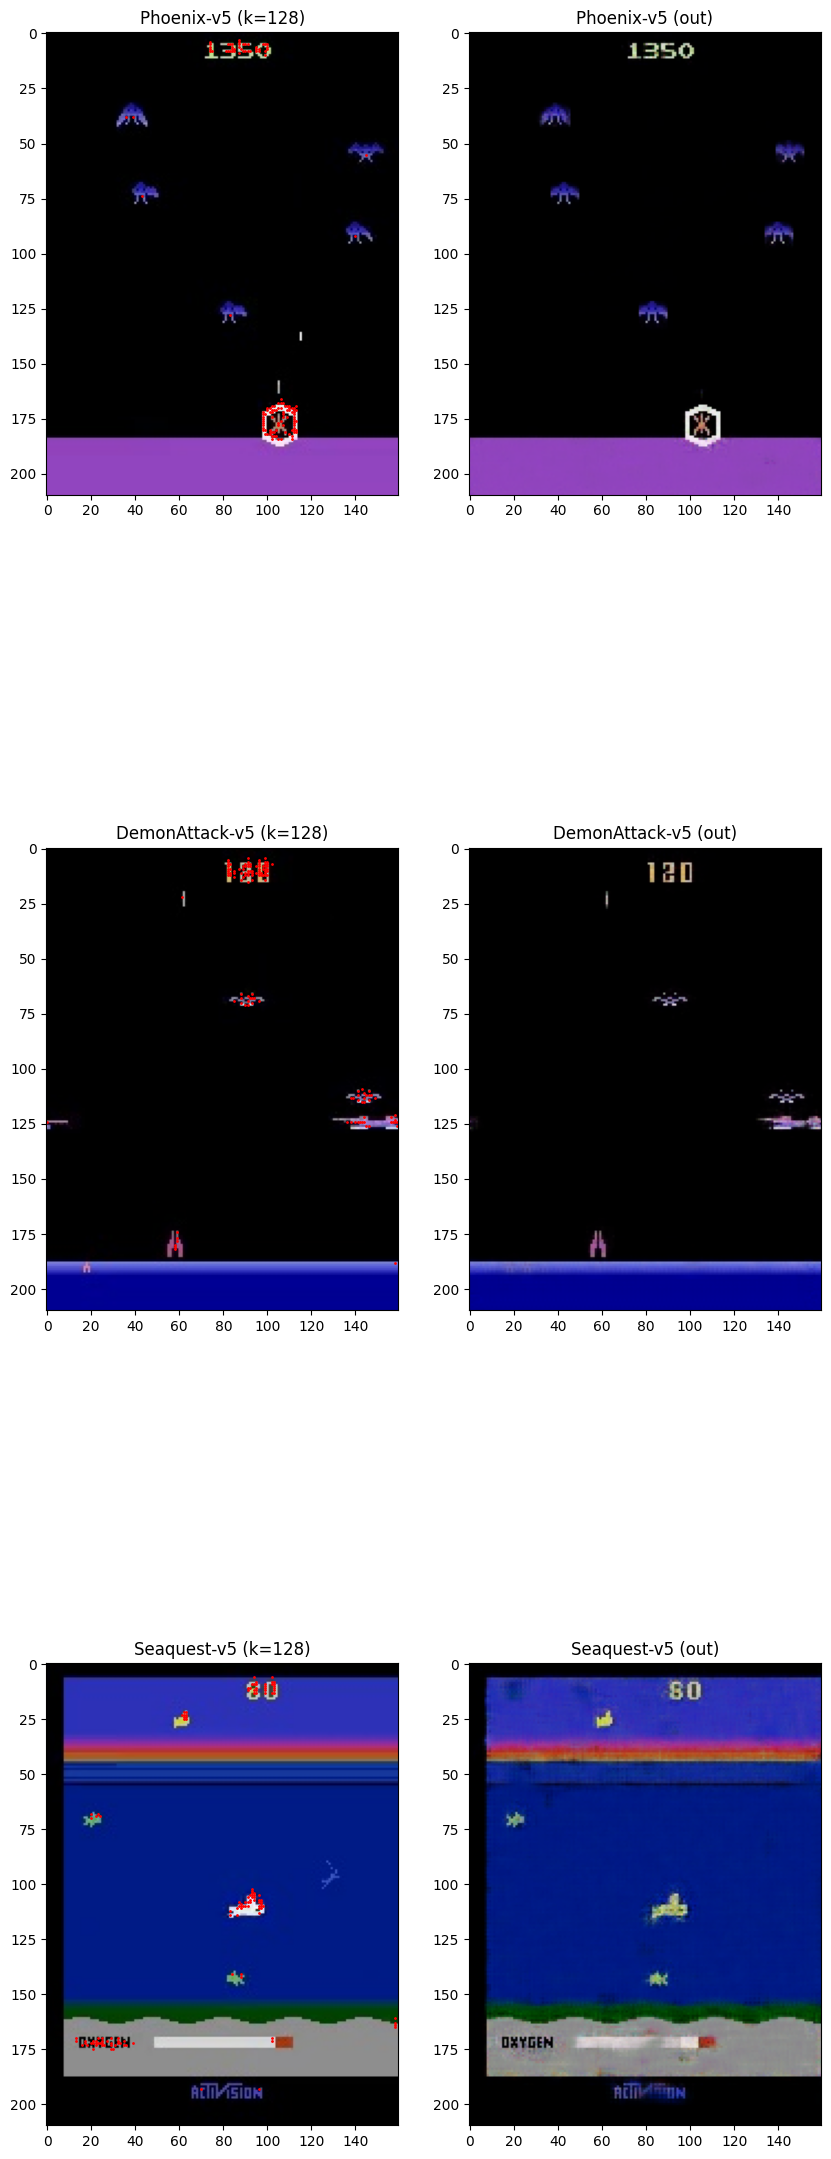

In [9]:
n = len(model.dsets_names)
fig, axs = plt.subplots(n, 2, figsize=(10, 30)) 

# axs[0,0].imshow(plottable_image(inp))
# axs[0,0].set_title(f'Input ({ENV_NAME})')

# new_inp = torch.from_numpy(np.random.random(inp.shape)).float()
# new_inp = torch.from_numpy(np.zeros(inp.shape)).float()

fe_only = model.fe

# Specify seed, to reproduce results
seed = 12347
np.random.seed(seed)

for env_name, ax1, ax2 in zip(model.dsets_names, axs.flatten()[0::2], axs.flatten()[1::2]): # Get split odd al even axes
    input_folder_full = INPUT_FOLDER + f'/{env_name}/val/'
    filename = np.random.choice(os.listdir(input_folder_full))
    input_path = input_folder_full + filename
    
    # Load input and obtain outpu
    inp = load_npy(input_path)
    out_t = model.forward(inp, env_name)
    
    # Get output of fe
    central = fe_only.forward(inp)
    assert len(central) == 3
    reduced_idx3, reduced_top3, idx = central
#     print(idx)
    hs, ws, _z, _b = unflatten_coords(idx, inp.shape)
    
    
    ax1.imshow(plottable_image(inp))
    ax1.set_title(f'{env_name} (k={idx.shape[-1]})')
    ax2.imshow(plottable_image(out_t))
    ax2.set_title(f'{env_name} (out)')
    
    for h, w in zip(hs, ws):
        ax1.scatter(h, w, s=1, color='red')
